In [1]:
# This is code for cz4042 final project
# Speech emotion recognition

# Keras
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD
# Other
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib.pyplot import specgram
import pandas as pd
import os
import sys
import warnings
import pickle
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
# To mount google drive when using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path for input files in google drive mounted
path = '/content/drive/My Drive/Colab Notebooks/inputs/'

In [5]:
# Define attention layer
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [19]:
# Load dataset
win_ts = 128
hop_ts = 64
only_radvess = True

melspec = np.load(path + 'mel_spec_data_1.npy')
ref = pd.read_pickle(path + "data_df_1.pkl")

In [15]:
# for test data loaded, commented after test
# print(melspec.shape)
# print(melspec)

(4320, 25920)
[[-80.         -80.         -80.         ... -72.21595615 -72.75324638
  -72.99821306]
 [-80.         -80.         -80.         ... -80.         -80.
  -80.        ]
 [-80.         -80.         -80.         ... -80.         -80.
  -80.        ]
 ...
 [-51.1737783  -55.42129429 -49.93207933 ... -51.65159314 -50.56064515
  -48.42263473]
 [-47.3655637  -42.18030928 -43.49441697 ... -44.79103672 -46.04742709
  -45.69791011]
 [-40.24184053 -40.90324922 -42.9602301  ... -43.4378793  -43.15244739
  -44.61463586]]


In [16]:
# print(ref.head)

<bound method NDFrame.head of      Emotion  ...                                               Path
0          5  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
1          6  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
2          6  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
3          5  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
4          7  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
...      ...  ...                                                ...
4315       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4316       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4317       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4318       1  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4319       1  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...

[4320 rows x 4 columns]>


In [23]:
# Split between train and test data, ratio of 1:3
X_train, X_test, y_train, y_test = train_test_split(
    melspec, ref.Emotion, test_size=0.25, shuffle=True, random_state=42)

X_train = X_train.squeeze()
X_test = X_test.squeeze()
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(X_train.shape)

(3240, 25920)


In [28]:
# for test only
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(1080, 25920)
(3240, 8)
(1080, 8)


In [35]:
# Reshape X train and test, for input into model, reshape the data being flattend in feature extraction part in order to easier save
X_train = X_train.reshape(3240, 2, 1, 60, 216)
X_test = X_test.reshape(1080, 2, 1, 60, 216)

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

# for test only
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3240, 2, 1, 60, 216)
(1080, 2, 1, 60, 216)
(3240, 8)
(1080, 8)


In [33]:
# Check the device used for training is GPU 
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

Selected device is cuda


In [36]:
# Model Disign

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1')(y)
y = TimeDistributed(Dropout(0.3), name='Drop_1')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2')(y)
y = TimeDistributed(Dropout(0.3), name='Drop_2')(y)


## Third LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3')(y)
y = TimeDistributed(Dropout(0.4), name='Drop_3')(y)

## Fourth LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4')(y)
y = TimeDistributed(Dropout(0.4), name='Drop_4')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat')(y)                      
                                
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=True, dropout=0.2, name='LSTM_1')(y)
y = attention(return_sequences=False)(y)


y = Flatten()(y)
y = Dense(64)(y)
y = Dropout(rate=0.4)(y)
y = BatchNormalization()(y)
y = Activation("relu")(y)
y = Dropout(rate=0.4)(y)

y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

model = Model(inputs=input_y, outputs=y)

model.compile(optimizer=Adam(lr=0.005, decay=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
# history = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_test, y_test), callbacks=[early_stopping])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                              batch_size=64, verbose=2, epochs=1500)

Epoch 1/1500
51/51 - 1s - loss: 2.3122 - accuracy: 0.1407 - val_loss: 2.1366 - val_accuracy: 0.1426
Epoch 2/1500
51/51 - 1s - loss: 2.0856 - accuracy: 0.1769 - val_loss: 2.0625 - val_accuracy: 0.1352
Epoch 3/1500
51/51 - 1s - loss: 1.9564 - accuracy: 0.2340 - val_loss: 1.9352 - val_accuracy: 0.1926
Epoch 4/1500
51/51 - 1s - loss: 1.8678 - accuracy: 0.2833 - val_loss: 1.8158 - val_accuracy: 0.2630
Epoch 5/1500
51/51 - 1s - loss: 1.8336 - accuracy: 0.2938 - val_loss: 1.6777 - val_accuracy: 0.3472
Epoch 6/1500
51/51 - 1s - loss: 1.7750 - accuracy: 0.3272 - val_loss: 1.7650 - val_accuracy: 0.3167
Epoch 7/1500
51/51 - 1s - loss: 1.7529 - accuracy: 0.3235 - val_loss: 1.6856 - val_accuracy: 0.3444
Epoch 8/1500
51/51 - 1s - loss: 1.7090 - accuracy: 0.3565 - val_loss: 1.6132 - val_accuracy: 0.3722
Epoch 9/1500
51/51 - 1s - loss: 1.6875 - accuracy: 0.3620 - val_loss: 1.5774 - val_accuracy: 0.3694
Epoch 10/1500
51/51 - 1s - loss: 1.6529 - accuracy: 0.3827 - val_loss: 1.8002 - val_accuracy: 0.3241

In [39]:
# Save accuracy to npy file for further use
np.save(path + 'att_acc.npy', np.array(history.history['accuracy']))

(1500,)

In [40]:
# test only
acc = np.load(path + 'att_acc.npy')
print(acc)

[0.14074074 0.17685185 0.23395061 ... 0.97191358 0.97006172 0.97283953]


In [41]:
# Save val_accuracy to npy file for further use
np.save(path + 'att_accval.npy', np.array(history.history['val_accuracy']))

In [43]:
# test only
valacc = np.load(path + 'att_accval.npy')
print(valacc)
print(valacc.shape)

[0.14259259 0.13518518 0.19259259 ... 0.95833331 0.96574074 0.96203703]
(1500,)


In [44]:
# Save loss to npy file for further use
np.save(path + 'att_lss.npy', np.array(history.history['loss']))

In [45]:
# test only
lss = np.load(path + 'att_lss.npy')
print(lss)
print(lss.shape)

[2.31222653 2.08563399 1.9564321  ... 0.10245315 0.09987894 0.09741514]
(1500,)


In [46]:
# Save val_loss to npy file for further use
np.save(path + 'att_vallss.npy', np.array(history.history['val_loss']))

In [47]:
# test only
vallss = np.load(path + 'att_vallss.npy')
print(vallss)
print(vallss.shape)

[2.1365695  2.06250691 1.93523717 ... 0.16952945 0.15729013 0.15793881]
(1500,)


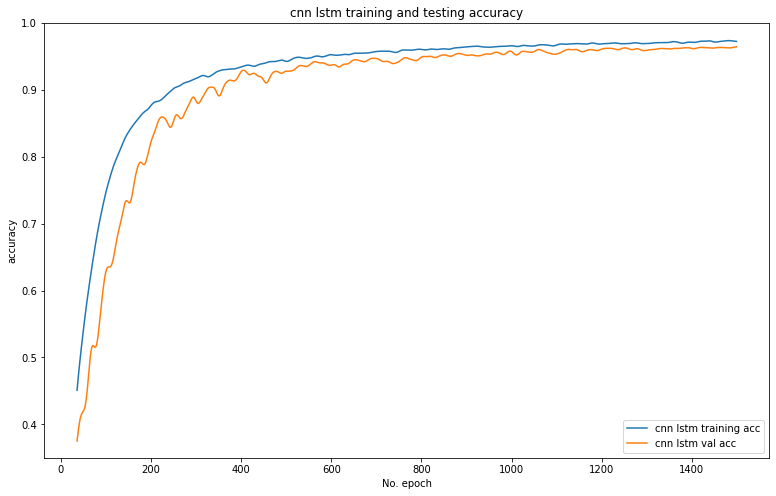

In [52]:
# plot curves - cnn lstm attention training and test accuracy
fig=plt.gcf()

history.history['accuracy'] = pd.Series(history.history['accuracy']).rolling(window=10).mean()
history.history['val_accuracy'] = pd.Series(history.history['val_accuracy']).rolling(window=10).mean()

axes = plt.gca()
axes.set_ylim([0.35,1])

plt.plot(history.history['accuracy'], label='cnn lstm attention training acc', c='#1f77b4')
plt.plot(history.history['val_accuracy'], label='cnn lstm attention val acc', c='#ff7f0e')

plt.title('cnn lstm attention training and testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

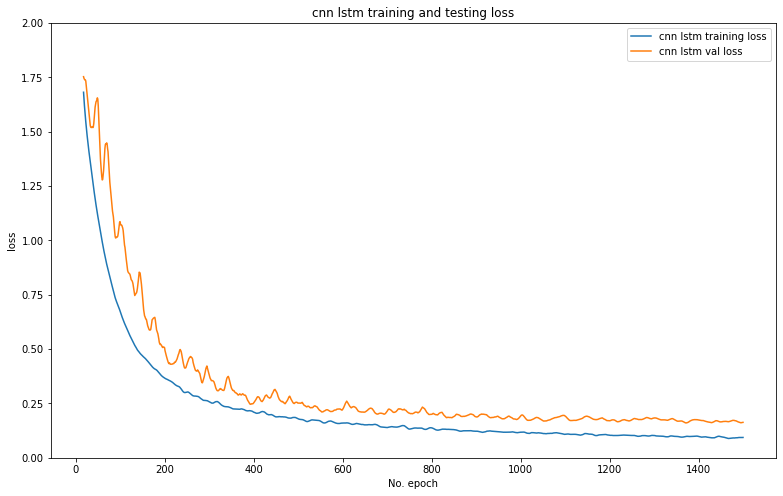

In [53]:
# plot curves - cnn lstm attention training and test loss
fig=plt.gcf()

axes = plt.gca()
axes.set_ylim([0,2])

history.history['loss'] = pd.Series(history.history['loss']).rolling(window=10).mean()
history.history['val_loss'] = pd.Series(history.history['val_loss']).rolling(window=10).mean()

plt.plot(history.history['loss'], label='cnn lstm attention training loss', c='#1f77b4')
plt.plot(history.history['val_loss'], label='cnn lstm attention val loss', c='#ff7f0e')

plt.title('cnn lstm training and testing loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

In [54]:
# emotion labels used for generating evaluation pictures
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0

In [67]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = model.predict(X_test)


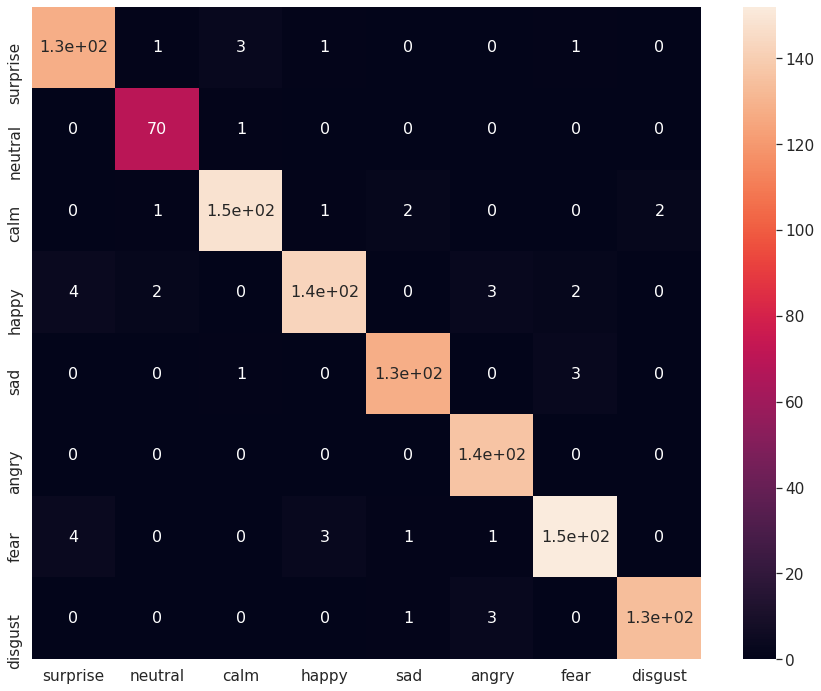

In [80]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
plt.figure(figsize=(15,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.savefig(
    f'/content/drive/My Drive/Colab Notebooks/results/att_confusion_matrix.png')
plt.show()

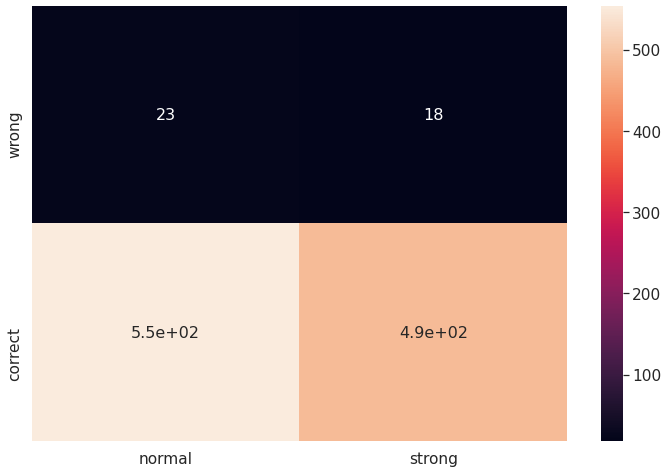

In [96]:
# correlation between emotion intensity and prediction
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = ref.loc[i,'Intensity']
    if y_test[i].argmax() == predictions[i].argmax(): # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
plt.figure(figsize=(12,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.savefig(
    f'/content/drive/My Drive/Colab Notebooks/results/att_correlation_Intensity_correctness.png')
plt.show()

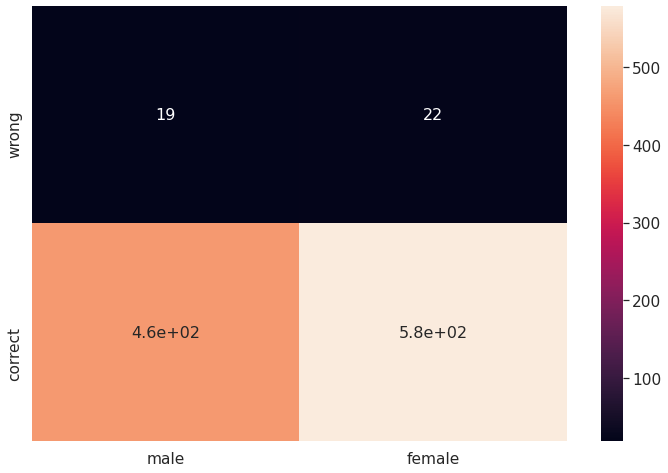

In [99]:
# correlation between gender and corectness
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = ref.loc[i,'Gender']
    if y_test[i].argmax() == predictions[i].argmax(): # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
plt.figure(figsize=(12,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.savefig(
    f'/content/drive/My Drive/Colab Notebooks/results/att_correlation_gender_correctness.png')
plt.show()